## Midterm project

CITATIONS:
- https://github.com/poojahira/gtsrb-pytorch
- https://github.com/surajmurthy/TSR_PyTorch

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from torch.utils import data
from torch.autograd import Variable
from torchvision.io import read_image

## Helper functions

In [2]:
class Net(nn.Module):
    def __init__(self, nclasses):
        super(Net, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(3, 100, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(100)
        self.conv2 = nn.Conv2d(100, 150, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(250)
        self.conv_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(250*2*2, 350)
        self.fc2 = nn.Linear(350, nclasses)

        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
            )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 4 * 4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
            )
   
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))


    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform forward pass
        x = self.bn1(F.max_pool2d(F.leaky_relu(self.conv1(x)),2))
        x = self.conv_drop(x)
        x = self.bn2(F.max_pool2d(F.leaky_relu(self.conv2(x)),2))
        x = self.conv_drop(x)
        x = self.bn3(F.max_pool2d(F.leaky_relu(self.conv3(x)),2))
        x = self.conv_drop(x)
        x = x.view(-1, 250*2*2)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
        
class FMnet(nn.Module):
    def __init__(
        self,
        n_classes,
        img_ch=1,
        channels=[16, 32, 64, 128, 200],
        device=['cuda' if torch.cuda.is_available() else 'cpu'][0],
        kernel=3,
        shape=(256, 256),
        n_upsample=4,
    ):
        super().__init__()
        self.n_upsample = n_upsample
        self.image_shape = shape
        self.device = device

        self.Conv = nn.Sequential()
        self.Conv.add_module(
            "conv0",
            convblock(ch_in=img_ch, ch_out=channels[0], kernel_sz=kernel, block=0),
        )
        for k in range(1, len(channels)):
            self.Conv.add_module(
                f"conv{k}",
                convblock(
                    ch_in=channels[k - 1], ch_out=channels[k], kernel_sz=kernel, block=k
                ),
            )

        self.Up_conv = nn.Sequential()
        for k in range(n_upsample):
            self.Up_conv.add_module(
                f"upconv{k}",
                convblock(
                    ch_in=channels[-1 - k] + channels[-2 - k],
                    ch_out=channels[-2 - k],
                    kernel_sz=kernel,
                ),
            )

        self.fc1 = nn.Linear(channels[-2 - k]*2*2, 350)
        self.fc2 = nn.Linear(350, n_classes)

    def forward(self, x, normalize=False, verbose=False):
        # encoding path
        xout = []
        x = self.Conv[0](x)
        xout.append(x)
        for k in range(1, len(self.Conv)):
            x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
            x = self.Conv[k](x)
            xout.append(x)

        for k in range(len(self.Up_conv)):
            x = F.interpolate(x, scale_factor=2, mode="nearest")
            x = self.Up_conv[k](torch.cat((x, xout[-2 - k]), axis=1))

        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


# Create a gaussian wavelet of a set bin size
def gaussian_wavelet(bin_size, sigma):
    x = np.arange(-bin_size // 2, bin_size // 2 + 1)
    gaussian = np.exp(-(x ** 2) / (2 * sigma ** 2))
    return gaussian / gaussian.sum()


class convblock(nn.Module):
    def __init__(self, ch_in, ch_out, kernel_sz, block=-1):
        super().__init__()
        self.conv = nn.Sequential()
        self.block = block
        if self.block != 0:
            self.conv.add_module("conv_0", batchconv(ch_in, ch_out, kernel_sz))
        else:
            self.conv.add_module("conv_0", batchconv0(ch_in, ch_out, kernel_sz))
        self.conv.add_module("conv_1", batchconv(ch_out, ch_out, kernel_sz))

    def forward(self, x):
        x = self.conv[1](self.conv[0](x))
        return x


def batchconv0(ch_in, ch_out, kernel_sz):
    return nn.Sequential(
        nn.BatchNorm2d(ch_in, eps=1e-5, momentum=0.1),
        nn.Conv2d(ch_in, ch_out, kernel_sz, padding=kernel_sz // 2, bias=False),
    )


def batchconv(ch_in, ch_out, sz):
    return nn.Sequential(
        nn.BatchNorm2d(ch_in, eps=1e-5, momentum=0.1),
        nn.ReLU(inplace=True),
        nn.Conv2d(ch_in, ch_out, sz, padding=sz // 2, bias=False),
    )

## Training

In [3]:
# TODO: Fix test data targets

In [4]:
# Define path of training data
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize([212, 256]),
    transforms.ToTensor()
    #transforms.Resize((32, 32)),
    #transforms.ToTensor(),
    #transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

train_data_path = '/home/stringlab/Desktop/DLCV_midterm_project/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images' 
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform=transform)

test_data_path = '/home/stringlab/Desktop/DLCV_midterm_project/GTSRB_Final_Test_Images/GTSRB'
test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform=transform)

# Divide data into training and validation 
ratio = 0.9
n_train_examples = int(len(train_data) * ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = data.random_split(train_data, [n_train_examples, n_val_examples])
print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")

Number of training samples = 35288
Number of validation samples = 3921


In [5]:
num_train_classes = len(train_data.dataset.classes)
train_hist = [0]*num_train_classes
for i in train_data.indices:
    tar = train_data.dataset.targets[i]
    train_hist[tar] += 1

num_val_classes = len(val_data.dataset.classes)
val_hist = [0]*num_val_classes
for i in val_data.indices:
    tar = val_data.dataset.targets[i]
    val_hist[tar] += 1

num_test_classes = len(np.unique(test_data.targets))
test_hist = [0]*num_test_classes
for i, t in enumerate(test_data.targets):
    test_hist[t] += 1

Text(0, 0.5, '# of examples')

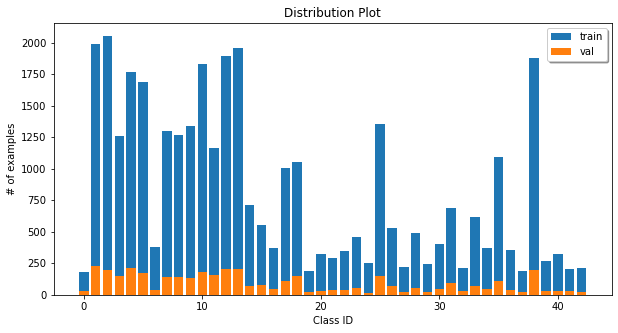

In [6]:
plt.figure(figsize=(10, 5))
plt.bar(range(num_train_classes), train_hist, label="train")
plt.bar(range(num_val_classes), val_hist, label="val")
#plt.bar(range(num_test_classes), test_hist, label="test")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

In [8]:
# Create data loader for training and validation
BATCH_SIZE = 100
LOG_INTERVAL = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = data.DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size = BATCH_SIZE)
test_loader = data.DataLoader(test_data, shuffle=True, batch_size = BATCH_SIZE)

# Neural Network and Optimizer
model = FMnet(num_train_classes)#Net()
model = model.to(device);

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)


In [9]:
model

FMnet(
  (Conv): Sequential(
    (conv0): convblock(
      (conv): Sequential(
        (conv_0): Sequential(
          (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (conv_1): Sequential(
          (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
    )
    (conv1): convblock(
      (conv): Sequential(
        (conv_0): Sequential(
          (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (conv_1): Sequential(
          (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

In [10]:
def train(epoch):
    model.train()
    correct = 0
    training_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)   
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        max_index = output.max(dim = 1)[1]
        correct += (max_index == target).sum()
        training_loss += loss
        if batch_idx % 2 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss per example: {:.6f}\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.data.item()/(BATCH_SIZE * LOG_INTERVAL),loss.data.item()))
    print('\nTraining set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                training_loss / len(train_loader.dataset), correct, len(train_loader.dataset),
                100. * correct / len(train_loader.dataset)))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, size_average=False).data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    scheduler.step(np.around(validation_loss,2))
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


In [12]:
for epoch in range(1, 50):
    train(epoch)
    validation()

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 28 but got size 27 for tensor number 1 in the list.